### Most of the code is directly taken and adapted from the cooltools docs at https://cooltools.readthedocs.io/en/latest/  zenodo DOI: 10.5281/zenodo.5214125

In [2]:
import cooltools
import bioframe
import cooler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os, subprocess
import scipy
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
from itertools import combinations
from matplotlib import colors
%matplotlib inline
plt.style.use('seaborn-poster')
from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.1'):
    raise AssertionError("please check your cooltools version and update to the latest")

from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

import cooltools.lib.plotting
from matplotlib.colors import LogNorm

* # P(s) and derivative

In [3]:
namelist = ['WT', 'Rad21KO', 'WaplcKO_merge']
resolutions = [5000]

In [4]:
dclr={}
for r in resolutions:
    dclr[r] = {}
    for  n in namelist:
            dclr[r][n] = cooler.Cooler(f'./my_coolers/proper_coolers/balanced_merged_cool/{n}_5000.cool')  

In [5]:
clr = dclr[5000]['WT']
mm10_chromsizes = bioframe.fetch_chromsizes('mm10')
mm10_cens = bioframe.fetch_centromeres('mm10') ### Mouse chromosomes are telocentric
mm10_chroms = bioframe.core.construction.add_ucsc_name_column(bioframe.make_chromarms(mm10_chromsizes,  mm10_cens))
mm10_chroms = mm10_chroms[mm10_chroms.chrom.isin(clr.chromnames)].reset_index(drop=True)

In [6]:
mm10_chroms = mm10_chroms[mm10_chroms.chrom != 'chrM'][mm10_chroms.chrom != 'chrY'][mm10_chroms.chrom != 'chrX']

cvd ={}
cvd_smooth_agg = {}
cvd_merged = {}
der = {}
derder={}
resolution = 5000
for n in namelist:
    cvd[n] = cooltools.expected_cis(
        clr=dclr[resolution][n],
        view_df=mm10_chroms,
        smooth=False,
        aggregate_smoothed=False,
        nproc=32
    )

    cvd[n]['s_bp'] = cvd[n]['dist']* resolution


    ###################################### SMOOTH AND AGGREGAGTE ######################################
    cvd_smooth_agg[n] = cooltools.expected_cis(
        clr=dclr[resolution][n],
        view_df=mm10_chroms,
        smooth=True,
        aggregate_smoothed=True,
        nproc=32
    )

    cvd_smooth_agg[n]['s_bp'] = cvd_smooth_agg[n]['dist']* resolution
    cvd_smooth_agg[n]['balanced.avg.smoothed'].loc[cvd_smooth_agg[n]['dist'] < 2] = np.nan


    ###################################### GLOBAL P(s) AND DERIVATIVE ######################################
    cvd_merged[n] = cvd_smooth_agg[n].drop_duplicates(subset=['dist'])[['s_bp', 'balanced.avg.smoothed.agg']]

    der[n] = np.gradient(np.log(cvd_merged[n]['balanced.avg.smoothed.agg']),
                      np.log(cvd_merged[n]['s_bp']))


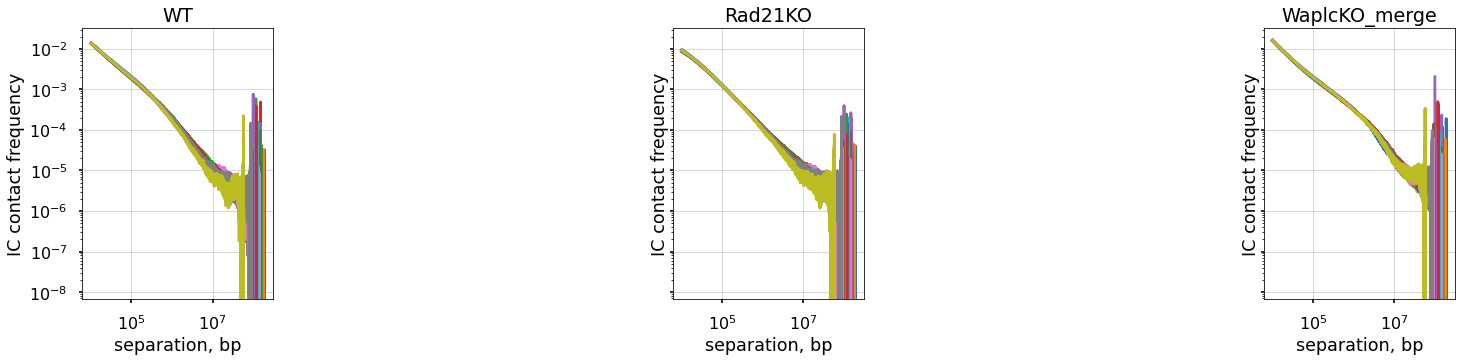

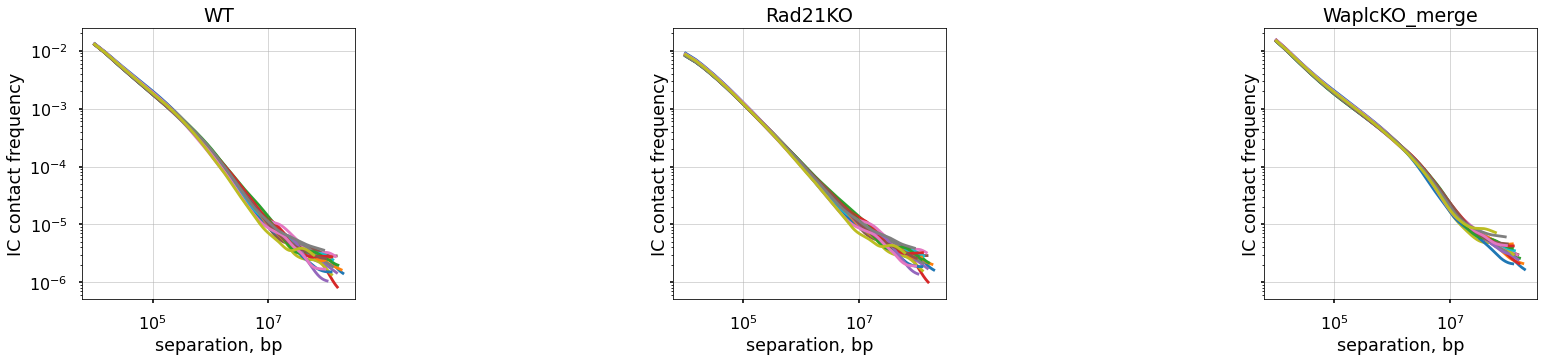

In [7]:
l = len(namelist)
f, axs = plt.subplots(1, l, figsize=(30, 5), sharey=True)
for i, n in enumerate(namelist):
    ax=axs[i]                 
    for region in mm10_chroms['name']:
        ax.loglog(
            cvd[n]['s_bp'].loc[cvd[n]['region1']==region],
            cvd[n]['balanced.avg'].loc[cvd[n]['region1']==region],
        label=region.split(':')[0])
        ax.set(
            xlabel='separation, bp',
            ylabel='IC contact frequency',
            title = n)
        ax.set_aspect(1)
        ax.grid(lw=0.5)
#ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10);

###################################### SMOOTH AND AGGREGAGTE ######################################

f, axs = plt.subplots(1, l, figsize=(30, 5), sharey=True)

for i, n in enumerate(namelist):
    ax=axs[i]
    for region in mm10_chroms['name']:
        ax.loglog(
            cvd_smooth_agg[n]['s_bp'].loc[cvd_smooth_agg[n]['region1']==region],
            cvd_smooth_agg[n]['balanced.avg.smoothed'].loc[cvd_smooth_agg[n]['region1']==region],
            label=region.split(':')[0])

        ax.set(
            xlabel='separation, bp',
            ylabel='IC contact frequency',
            title = n)
        ax.set_aspect(1.0)
        ax.grid(lw=0.5)

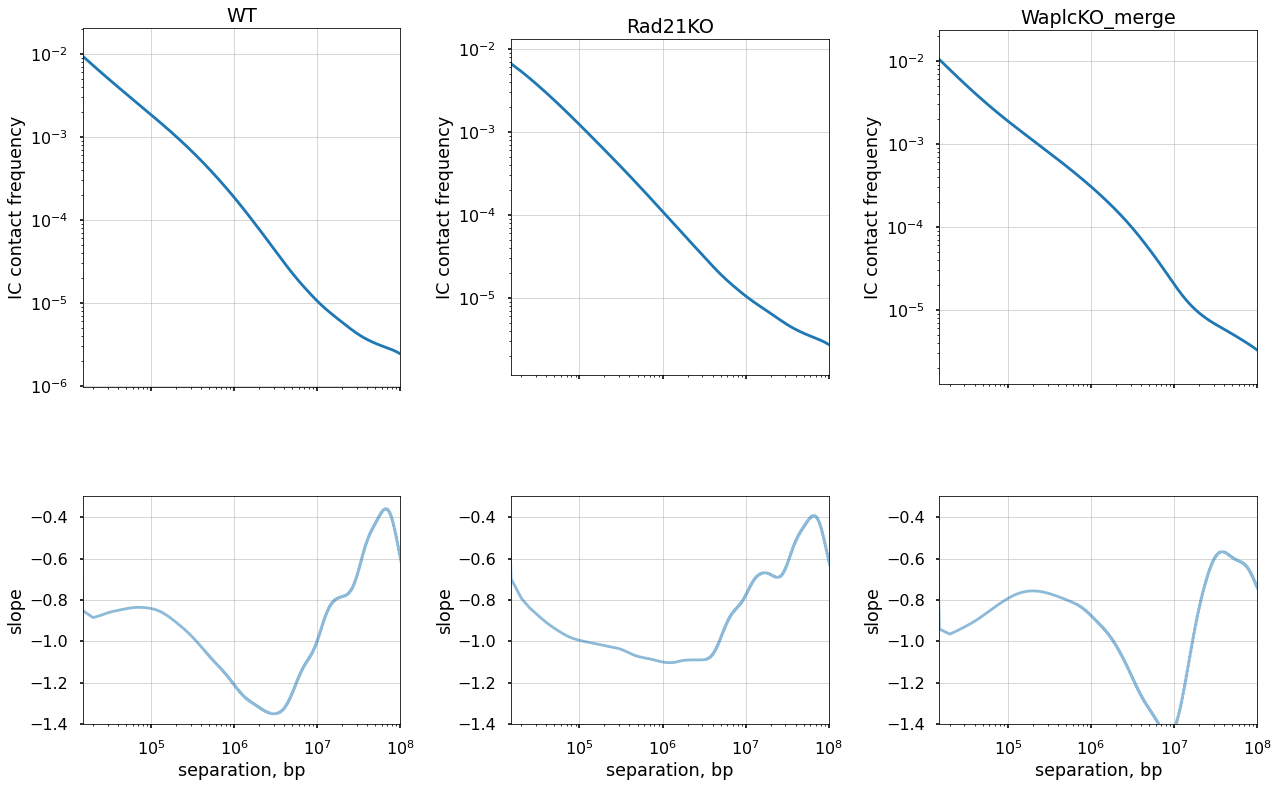

In [8]:
###################################### GLOBAL P(s) AND DERIVATIVE ######################################

f, axs = plt.subplots(
    figsize=(6*l,13),
    ncols=len(namelist),
    nrows=2,
    gridspec_kw={'height_ratios':[6,2]},
    sharex=True)
                      
for i, n in enumerate(namelist):
    ax=axs[0, i]
    ax.loglog(
        cvd_merged[n]['s_bp'],
        cvd_merged[n]['balanced.avg.smoothed.agg'],
        '-',
        markersize=5,
    )

    ax.set(
        ylabel='IC contact frequency',
        xlim=(1.5e4,1e8),
        title = n
    )
    ax.set_aspect(1.0)
    ax.grid(lw=0.5)


    ax = axs[1, i]
    ax.semilogx(
        cvd_merged[n]['s_bp'],
        der[n],
        alpha=0.5
    )

    ax.set(
        xlabel='separation, bp',
        ylabel='slope',
        xlim=(1.5e4,1e8),
        ylim=(-1.4, -0.3)
)

    ax.grid(lw=0.5)
plt.tight_layout()

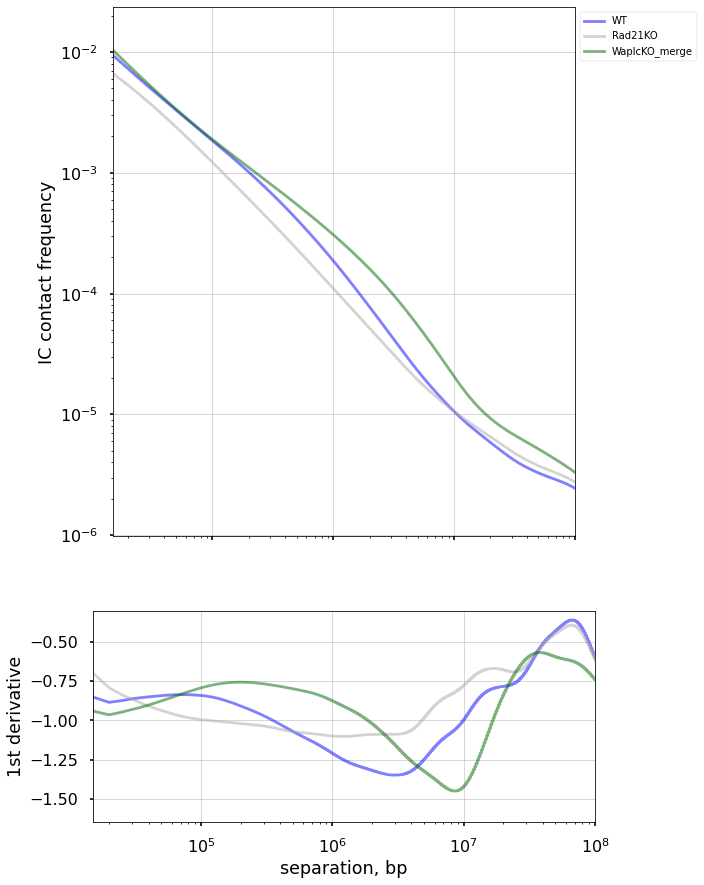

In [9]:
###################################### GLOBAL P(s) AND DERIVATIVE ######################################

f, axs = plt.subplots(
    figsize=(9, 15),
    ncols=1,
    nrows=2,
    gridspec_kw={'height_ratios':[5,2]},
    sharex=True)
                      
for i, (n, c) in enumerate(zip(namelist , ['b', 'darkgrey', 'darkgreen', 'lightgreen'])):
    ax=axs[0]
    merged = cvd_merged
    deriv = der
    ax.loglog(
        merged[n]['s_bp'],
        merged[n]['balanced.avg.smoothed.agg'],
        '-',
        label=n,
        color=c,
        alpha=0.5,
        markersize=5,
    )

    ax.set(
        ylabel='IC contact frequency',
        xlim=(1.5e4,1e8),
      #  title +=n
    )
    ax.set_aspect(1.0)
    ax.grid(lw=0.5)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10);


    ax = axs[1]
    ax.semilogx(
        merged[n]['s_bp'],
        deriv[n],
        label=n,
        color=c,
        alpha=0.5,
    )

    ax.set(
        xlabel='separation, bp',
        ylabel='1st derivative',
        xlim=(1.5e4,1e8),
        ylim=(-1.65, -0.3)
)
    ax.grid(lw=0.5)

* # Pcdh locus HiC map and insulation scores

In [1]:
def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [8]:
resolutions =[5000, 50000] 

namelist = ['WT_omp', 'WAPLcKO_merge'] 
pathlist = [f'/media/daniele/Rosalin/Simon/4DN_files/omp.mcool::resolutions/5000', f'{path}/WaplcKO_merge_5000.cool']

dclr={}
for r in resolutions:
    dclr[r] = {}
    for  n, p in zip(namelist, pathlist):
            dclr[r][n] = cooler.Cooler(p)   

In [9]:
clr = dclr[5000]['WT_omp']
mm10_chromsizes = bioframe.fetch_chromsizes('mm10')
mm10_cens = bioframe.fetch_centromeres('mm10') ### Mouse chromosomes are telocentric
mm10_chroms = bioframe.core.construction.add_ucsc_name_column(bioframe.make_chromarms(mm10_chromsizes,  mm10_cens))
mm10_chroms = mm10_chroms[mm10_chroms.chrom.isin(clr.chromnames)].reset_index(drop=True)

In [21]:
start, end = 36_000_000, 38_000_000
region = f'chr18:{start}-{end}'
testname = ['WT', 'WaplcKO_merge']

myclr = {}
for n in testname:
    myclr[n] = cooler.Cooler(f'./my_coolers/proper_coolers/balanced_merged_cool/{n}_5000.cool')


cg={}
cgi={}
for n in testname:
    cg[n] = adaptive_coarsegrain(myclr[n].matrix(balance=True).fetch(region),
                              myclr[n].matrix(balance=False).fetch(region),
                              cutoff=1, max_levels=8)
    cgi[n] = interp_nan(cg[n])

In [22]:
isle = {}
for n in testname:
    isle[n] = pd.read_csv(f'./my_coolers/proper_coolers/balanced_merged_cool/{n}_5000_IS50-100.csv', sep='\t')
    isle[n] = isle[n][~isle[n].is_bad_bin]

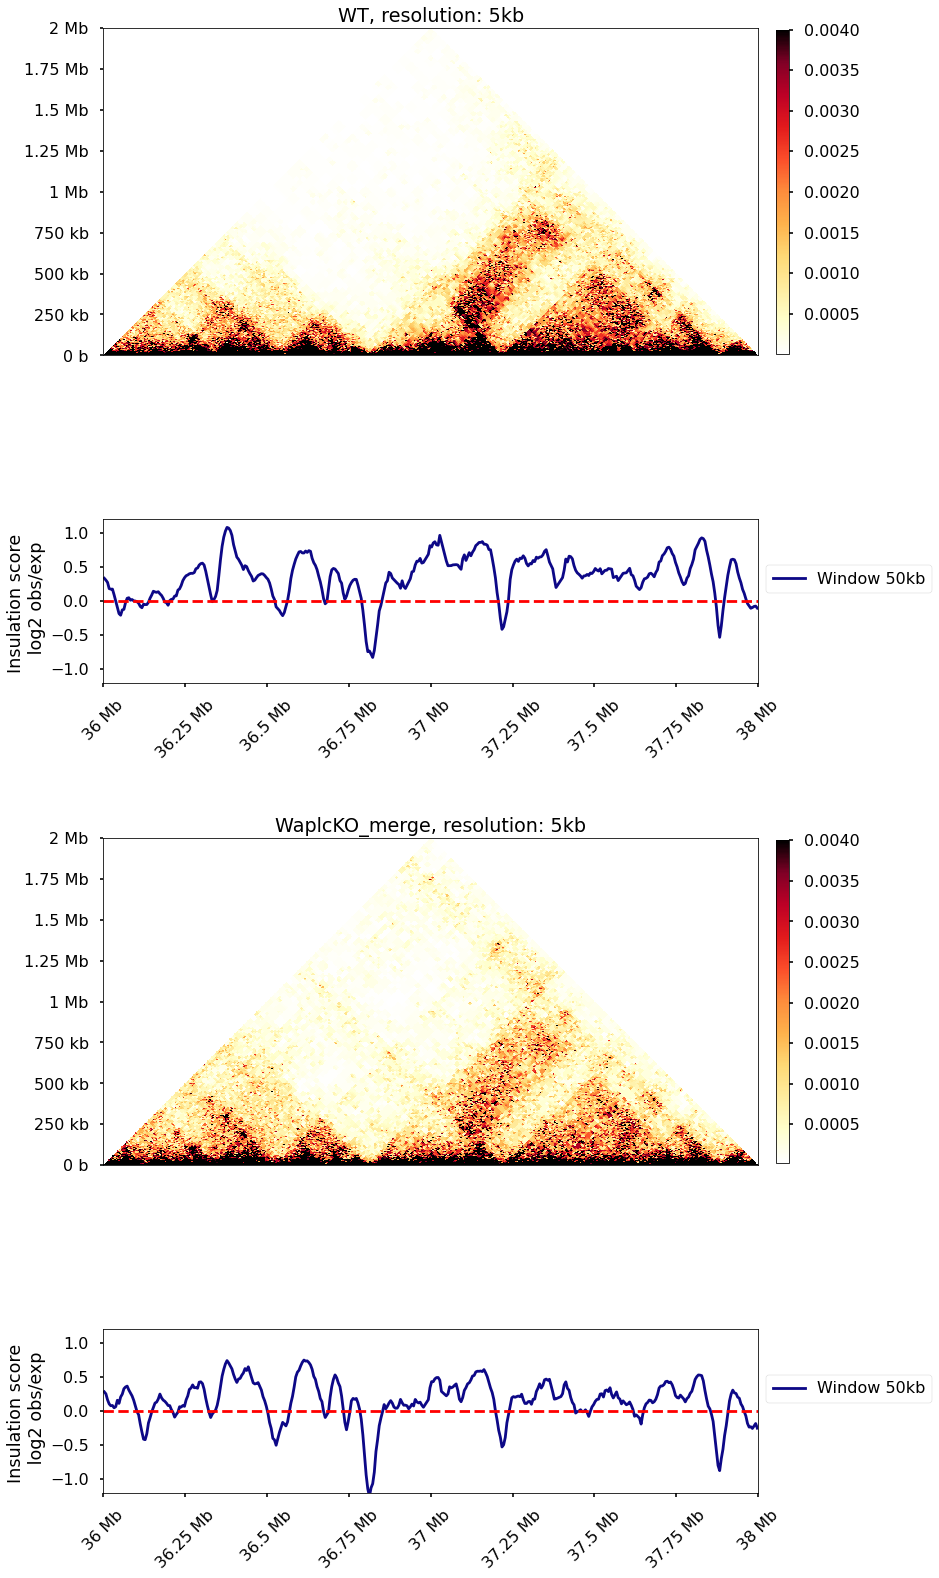

In [30]:
region = ('chr18', 36000000, 38000000)

from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe
plt.rcParams['font.size'] = 10

resolution = 5000

f, axs = plt.subplots(len(testname), 1, figsize=(35, 12*len(testname)))

for i, n in enumerate(testname):
    ax=axs[i]
    clr = cgi[n]
    region = region
    IS = isle[n]
    data= clr
    im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, 
                          #norm=norm,
                          vmax=0.004,
                         cmap= 'fall')
    ax.set_aspect(0.5)
    ax.set_ylim(0, 2_000_000)
    format_ticks(ax, rotate=True)
    ax.xaxis.set_visible(False)
    
    ax.set_title(f'{n}, resolution: {resolution//1000}kb')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=.25, aspect=6200)
    plt.colorbar(im, cax=cax)
    
    insul_region = bioframe.select(IS, region)
    ins_ax = divider.append_axes("bottom", size="25%", pad=0., sharex=ax)
    ins_ax.set_prop_cycle(plt.cycler("color", plt.cm.plasma(np.linspace(0,1,5))))
   
    windows=[50000]
    for w, c1, c2 in zip(windows, ['lightblue', 'lightgreen', 'yellow'] ,['darkblue', 'darkgreen', 'orange']):
        ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
                    insul_region['log2_insulation_score_'+str(w)],
                    label=f'Window {w//1000}kb') 
        ins_ax.set_ylabel('Insulation score \n log2 obs/exp')

    format_ticks(ins_ax, y=False, rotate=True))
    ax.set_xlim(region[1], region[2])
    ins_ax.set_ylim(-1.2, 1.2)
    plt.axhline(0, color = 'r', linestyle= '--');
plt.tight_layout()